Cutoff 0.00: 80 clusters
Cutoff 11.11: 80 clusters
Cutoff 22.22: 73 clusters
Cutoff 33.33: 60 clusters
Cutoff 44.44: 34 clusters
Cutoff 55.56: 12 clusters
Cutoff 66.67: 4 clusters
Cutoff 77.78: 3 clusters
Cutoff 88.89: 2 clusters
Cutoff 100.00: 1 clusters


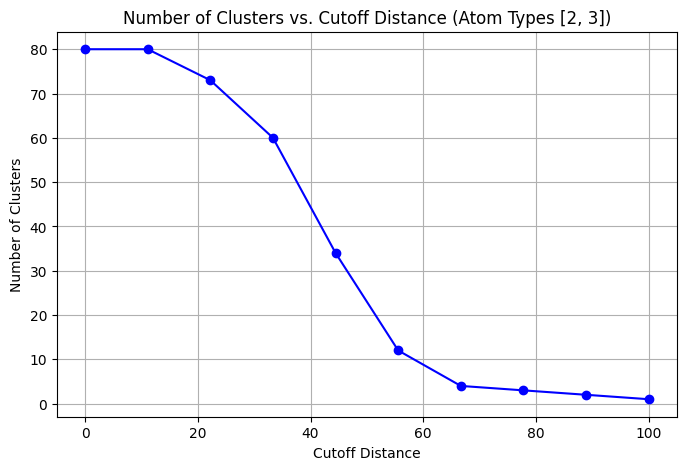

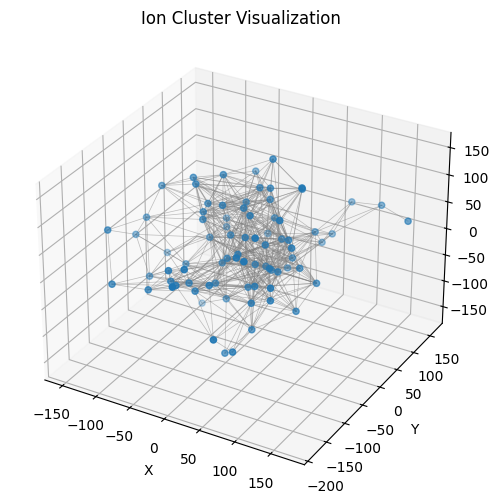

In [33]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from mpl_toolkits.mplot3d import Axes3D

def read_lammpstrj(filename, target_timestep=None, atom_types=None):
    """
    LAMMPS .lammpstrj 파일에서 특정 atom type 리스트와 timestep의 원자 좌표를 읽는 함수
    """
    with open(filename, 'r') as file:
        lines = file.readlines()

    atoms = []
    reading = False
    atom_types = set(atom_types) if atom_types else None  # 리스트를 set으로 변환 (검색 속도 향상)

    for i, line in enumerate(lines):
        if "ITEM: TIMESTEP" in line:
            timestep = int(lines[i+1].strip())
            if target_timestep is None or timestep == target_timestep:
                reading = True
            else:
                reading = False

        if reading and "ITEM: ATOMS" in line:
            for j in range(i+1, len(lines)):
                if "ITEM:" in lines[j]:
                    break
                parts = lines[j].strip().split()
                atom_id = int(parts[0])  # 원자 ID
                atom_type_id = int(parts[1])  # 원자 타입
                x, y, z = float(parts[2]), float(parts[3]), float(parts[4])  # 좌표

                # 여러 개의 atom type 선택 가능
                if atom_types is None or atom_type_id in atom_types:
                    atoms.append([x, y, z])

    return np.array(atoms)

def find_clusters(atoms, threshold):
    """
    원자 좌표를 기반으로 거리 기준(threshold)으로 클러스터를 찾는 함수
    """
    if len(atoms) == 0:
        return [], nx.Graph()  # 원자가 없으면 빈 클러스터 반환

    dist_matrix = distance_matrix(atoms, atoms)  # 거리 행렬 계산
    G = nx.Graph()

    for i in range(len(atoms)):
        G.add_node(i)

    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            if dist_matrix[i, j] < threshold:
                G.add_edge(i, j)

    clusters = list(nx.connected_components(G))
    return clusters, G

def visualize_clusters(atoms, clusters, G):
    """
    클러스터링 결과를 3D로 시각화하는 함수
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 각 클러스터에 대해 다른 색상 지정
    colors = plt.cm.tab10.colors  # 10가지 색상을 사용
    for i, cluster in enumerate(clusters):
        cluster_points = np.array([atoms[idx] for idx in cluster])
        color = colors[i % len(colors)]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
                   label=f'Cluster {i+1}', s=20, color=color)

    # 엣지(연결선) 추가
    for edge in G.edges():
        point1, point2 = atoms[edge[0]], atoms[edge[1]]
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], 
                color='gray', alpha=0.5, linewidth=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    #ax.legend()
    plt.title("Ion Cluster Visualization")
    plt.show()

def cluster_analysis(filename, target_timestep, atom_types, thresholds):
    """
    특정 atom types을 대상으로 다양한 cutoff 거리별로 클러스터 개수를 계산하고 시각화
    """
    atoms = read_lammpstrj(filename, target_timestep, atom_types)

    if len(atoms) == 0:
        print(f"No atoms found for atom types {atom_types}")
        return

    cluster_counts = []
    for threshold in thresholds:
        clusters, G = find_clusters(atoms, threshold)
        cluster_counts.append(len(clusters))
        print(f"Cutoff {threshold:.2f}: {len(clusters)} clusters")

    # 클러스터 개수 변화 그래프
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, cluster_counts, marker='o', linestyle='-', color='b')
    plt.xlabel("Cutoff Distance")
    plt.ylabel("Number of Clusters")
    plt.title(f"Number of Clusters vs. Cutoff Distance (Atom Types {atom_types})")
    plt.grid()
    plt.show()

    # 마지막 threshold의 클러스터 시각화
    visualize_clusters(atoms, clusters, G)

# 실행 예제
filename = "/Users/kimdaehyeok/Desktop/Kimgroup/Project/GCMD/data/0.02-2eqNM/spm_lj_end.lammpstrj"
target_timestep = 5500000  # 특정 타임스텝 선택 (None이면 마지막 사용)
atom_types = [2,3]  # 특정 원자 타입 선택 (여러 개 가능)
thresholds = np.linspace(0.0, 100, 10)  # 2.0~6.0 사이 5단계로 분석

cluster_analysis(filename, target_timestep, atom_types, thresholds)


Cutoff 0.00: 80 clusters
Cutoff 11.11: 67 clusters
Cutoff 22.22: 36 clusters
Cutoff 33.33: 17 clusters
Cutoff 44.44: 4 clusters
Cutoff 55.56: 3 clusters
Cutoff 66.67: 2 clusters
Cutoff 77.78: 1 clusters
Cutoff 88.89: 1 clusters
Cutoff 100.00: 1 clusters


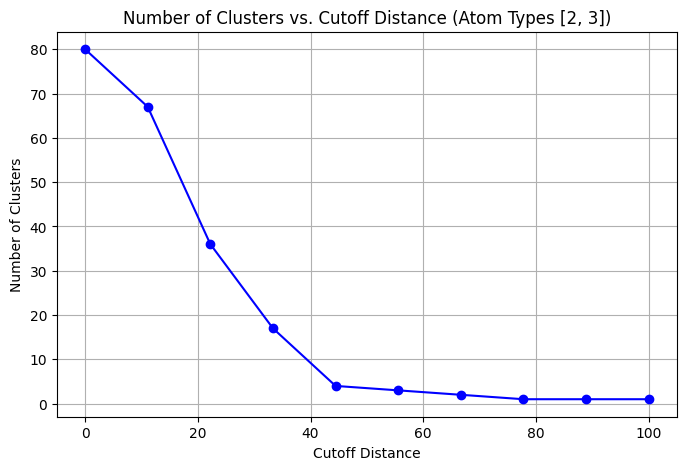

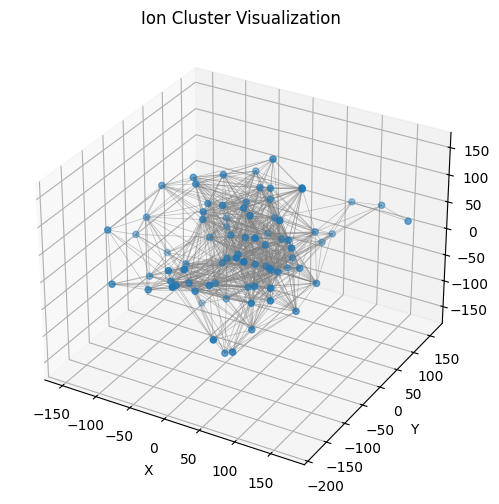

In [36]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_lammpstrj(filename, target_timestep=None, atom_types=None):
    """
    LAMMPS .lammpstrj 파일에서 특정 atom type 리스트와 timestep의 원자 좌표를 읽고, 박스 크기를 반환
    """
    with open(filename, 'r') as file:
        lines = file.readlines()

    atoms = []
    reading = False
    box_bounds = None
    atom_types = set(atom_types) if atom_types else None  # 검색 속도 향상

    for i, line in enumerate(lines):
        if "ITEM: TIMESTEP" in line:
            timestep = int(lines[i+1].strip())
            if target_timestep is None or timestep == target_timestep:
                reading = True
            else:
                reading = False

        if reading and "ITEM: BOX BOUNDS" in line:
            box_bounds = np.array([list(map(float, lines[i+j+1].strip().split())) for j in range(3)])

        if reading and "ITEM: ATOMS" in line:
            for j in range(i+1, len(lines)):
                if "ITEM:" in lines[j]:
                    break
                parts = lines[j].strip().split()
                atom_type_id = int(parts[1])
                x, y, z = float(parts[2]), float(parts[3]), float(parts[4])
                
                if atom_types is None or atom_type_id in atom_types:
                    atoms.append([x, y, z])

    return np.array(atoms), box_bounds

def pbc_distance(r1, r2, box_size):
    """
    주기적 경계 조건을 고려한 거리 계산
    """
    delta = np.abs(r1 - r2)
    delta = np.minimum(delta, box_size - delta)  # 최소 이미지 기준 적용
    return np.sqrt((delta ** 2).sum())

def find_clusters(atoms, box_bounds, threshold):
    """
    원자 좌표를 기반으로 PBC 적용하여 클러스터 찾기
    """
    if len(atoms) == 0:
        return [], nx.Graph()

    box_size = box_bounds[:, 1] - box_bounds[:, 0]
    G = nx.Graph()
    
    for i in range(len(atoms)):
        G.add_node(i)
    
    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            if pbc_distance(atoms[i], atoms[j], box_size) < threshold:
                G.add_edge(i, j)
    
    clusters = list(nx.connected_components(G))
    return clusters, G

def visualize_clusters(atoms, clusters, G):
    """
    클러스터링 결과를 3D로 시각화
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.tab10.colors
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array([atoms[idx] for idx in cluster])
        color = colors[i % len(colors)]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {i+1}', s=20, color=color)
    
    for edge in G.edges():
        point1, point2 = atoms[edge[0]], atoms[edge[1]]
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], color='gray', alpha=0.5, linewidth=0.5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("Ion Cluster Visualization")
    plt.show()

def cluster_analysis(filename, target_timestep, atom_types, thresholds):
    """
    다양한 cutoff 거리별로 클러스터 개수를 분석하고 시각화
    """
    atoms, box_bounds = read_lammpstrj(filename, target_timestep, atom_types)
    if len(atoms) == 0:
        print(f"No atoms found for atom types {atom_types}")
        return
    
    cluster_counts = []
    for threshold in thresholds:
        clusters, G = find_clusters(atoms, box_bounds, threshold)
        cluster_counts.append(len(clusters))
        print(f"Cutoff {threshold:.2f}: {len(clusters)} clusters")
    
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, cluster_counts, marker='o', linestyle='-', color='b')
    plt.xlabel("Cutoff Distance")
    plt.ylabel("Number of Clusters")
    plt.title(f"Number of Clusters vs. Cutoff Distance (Atom Types {atom_types})")
    plt.grid()
    plt.show()
    
    visualize_clusters(atoms, clusters, G)

# 실행 예제
filename = "/Users/kimdaehyeok/Desktop/Kimgroup/Project/GCMD/data/0.02-2eqNM/spm_lj_end.lammpstrj"
target_timestep = 5500000  
atom_types = [2,3]  
thresholds = np.linspace(0.0, 100, 10) 

cluster_analysis(filename, target_timestep, atom_types, thresholds)
